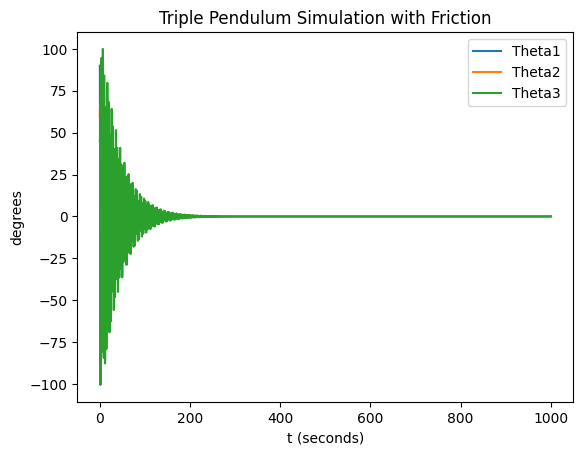

In [7]:
from __future__ import division, print_function
from math import sin, cos, pi
import numpy as np
from pylab import plot, xlabel, ylabel, show
import matplotlib.pyplot as plt
from numpy import array, arange, zeros_like
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures


# Physical constants
g = 9.81  # Acceleration due to gravity (m/s^2)
l1 = 1.0  # Length of the first pendulum (m)
l2 = 1.0  # Length of the second pendulum (m)
l3 = 1.0  # Length of the third pendulum (m)
m1 = 1.0  # Mass of the first pendulum (kg)
m2 = 1.0  # Mass of the second pendulum (kg)
m3 = 1.0  # Mass of the third pendulum (kg)

# Friction/damping coefficients
damping1 = 0.05  # Damping for the first pendulum
damping2 = 0.05  # Damping for the second pendulum
damping3 = 0.05  # Damping for the third pendulum

def f(q, t):
    '''Triple Pendulum equation of motion with friction'''
    theta1, omega1, theta2, omega2, theta3, omega3 = q

    # Useful constants
    m12 = m2 + m3
    m012 = m1 + m2 + m3
    mf = m012 / 4

    # Useful sines and cosines
    sin0 = sin(theta1)
    sin1 = sin(theta2)
    sin2 = sin(theta3)
    cos01 = cos(theta1 - theta2)
    cos02 = cos(theta1 - theta3)
    cos12 = cos(theta2 - theta3)
    sin01 = sin(theta1 - theta2)
    sin02 = sin(theta1 - theta3)
    sin12 = sin(theta2 - theta3)

    # Recurrent patterns
    r1 = m12 * cos01 * cos02 - m012 * cos12
    r2 = m012 - m12 * cos01**2
    r3 = -m012 + m3 * cos02**2

    # Parts of the first equation
    od1_1 = 4 * m3 * m12
    od1_2 = r1 * cos01 + r2 * cos02
    od1_3 = -g * sin2 + l1 * sin02 * omega1**2 + l2 * sin12 * omega2**2
    od1_4 = (-g * (m2 + m3) * sin1
             + l1 * (m2 + m3) * sin01 * omega1**2
             - l3 * m3 * sin12 * omega3**2)
    od1_5 = -m3 * m12 * (cos02 - cos(theta1 - 2 * theta2 + theta3))**2 * m012
    od1_6 = (g * m012 * sin0
             + l2 * m12 * sin01 * omega2**2
             + l3 * m3 * sin02 * omega3**2)
    od1_7 = m3 * r1**2 + m12 * r3 * r2

    # Parts of the second equation
    od2_1 = -g * sin2 + l1 * sin02 * omega1**2 + l2 * sin12 * omega2**2
    od2_2 = g * m012 * sin0 + l2 * m12 * sin01 * omega2**2 + l3 * m3 * sin02 * omega3**2
    od2_3 = -g * (m2 + m3) * sin1 + l1 * (m2 + m3) * sin01 * omega1**2 - l3 * m3 * sin12 * omega3**2

    # Parts of the third equation
    od3_1 = g * m012 * sin0 + l2 * m12 * sin01 * omega2**2 + l3 * m3 * sin02 * omega3**2
    od3_2 = -g * sin2 + l1 * sin02 * omega1**2 + l2 * sin12 * omega2**2
    od3_3 = g * (m2 + m3) * sin1 - l1 * (m2 + m3) * sin01 * omega1**2 + l3 * m3 * sin12 * omega3**2

    # ThetaDot equations
    td1 = omega1
    td2 = omega2
    td3 = omega3

    # OmegaDot equations
    od1 = (mf * (od1_1 * od1_2 * od1_3 * r2
           - 4 * (-m3 * od1_2 * r1
                  + (m3 * r1**2 + m12 * r3 * r2) * cos01) * od1_4
           - (od1_5 + 4 * m3 * r1**2 + 4 * m12 * r3 * r2) * od1_6)
           / (l1 * od1_7 * m012 * r2)) - damping1 * omega1

    od2 = ((-m3 * r1 * m012 * od2_1 * r2
           - (m3 * (r1 * cos01 + r2 * cos02) * r1
              - (m3 * r1**2 + m12 * r3 * r2) * cos01) * od2_2
           + m012 * r3 * r2 * od2_3)
           / (l2 * od1_7 * r2)) - damping2 * omega2

    od3 = (-(m12 * od1_2 * od3_1
           + m12 * m012 * od3_2 * r2
           - r1 * m012 * od3_3)
           / (l3 * (m3 * r1**2 + m12 * r3 * r2))) - damping3 * omega3

    return array([td1, od1, td2, od2, td3, od3], float)

a = 0.0
b = 1000
N = 100000
h = (b - a) / N

tpoints = np.arange(a, b, h)
theta1_points = np.zeros_like(tpoints)  # Preallocate arrays with zeros
theta2_points = np.zeros_like(tpoints)
theta3_points = np.zeros_like(tpoints)

q = np.array([np.pi / 2, 0, np.pi / 3, 0, np.pi / 4, 0], float)  # Initial conditions

for i, t in enumerate(tpoints):
    theta1_points[i] = q[0] * 180 / np.pi  # Convert to degrees
    theta2_points[i] = q[2] * 180 / np.pi
    theta3_points[i] = q[4] * 180 / np.pi

    k1 = h * f(q, t)
    k2 = h * f(q + 0.5 * k1, t + 0.5 * h)
    k3 = h * f(q + 0.5 * k2, t + 0.5 * h)
    k4 = h * f(q + k3, t + h)
    q += (k1 + 2 * k2 + 2 * k3 + k4) / 6

plt.plot(tpoints, theta1_points, label='Theta1')
plt.plot(tpoints, theta2_points, label='Theta2')
plt.plot(tpoints, theta3_points, label='Theta3')
plt.title("Triple Pendulum Simulation with Friction")
xlabel("t (seconds)")
ylabel("degrees")
plt.legend()
plt.show()

In [2]:
data = np.stack((theta1_points, theta2_points, theta3_points), axis=1)
np.save('pendulum_data.npy', data)

data = np.load('pendulum_data.npy')

# Normalize the data
scaler = MinMaxScaler()
data = scaler.fit_transform(data)

# Function to the sequences
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

#Function for polynomial mapping
def polynomial_feature_mapping(data, degree):
    poly = PolynomialFeatures(degree)
    return poly.fit_transform(data)

# Hyperparameters
SEQ_LENGTH = 64
POLY_DEGREE = 2

# Create sequences
SEQ_LENGTH = 50
X, y = create_sequences(data, SEQ_LENGTH)

# Split the data into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Apply polynomial feature mapping
X_train = polynomial_feature_mapping(X_train.reshape(-1, 2 * SEQ_LENGTH), POLY_DEGREE)
X_val = polynomial_feature_mapping(X_val.reshape(-1, 2 * SEQ_LENGTH), POLY_DEGREE)
X_test = polynomial_feature_mapping(X_test.reshape(-1, 2 * SEQ_LENGTH), POLY_DEGREE)

# Split the data into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Reshape the data for LinearRegression
X_train = X_train.reshape(X_train.shape[0], -1)
X_val = X_val.reshape(X_val.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)
y_train = y_train.reshape(y_train.shape[0], -1)
y_val = y_val.reshape(y_val.shape[0], -1)
y_test = y_test.reshape(y_test.shape[0], -1)

Train RMSE: 0.0000000024
Train R^2 Score: 0.9999999999999972
Validation RMSE: 0.0000000295
Validation R^2 Score: 0.9999999999995374
Test RMSE: 0.0000000290
Test R^2 Score: 0.999999999999622


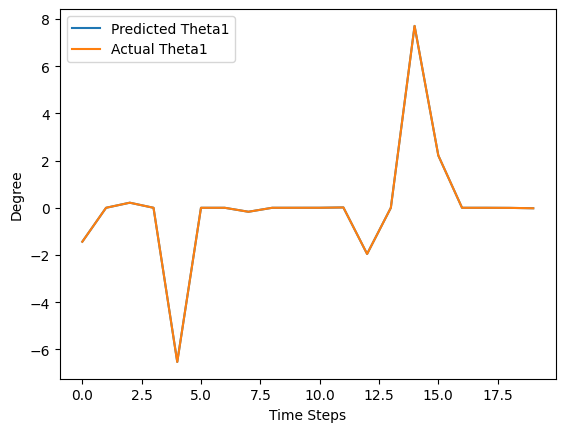

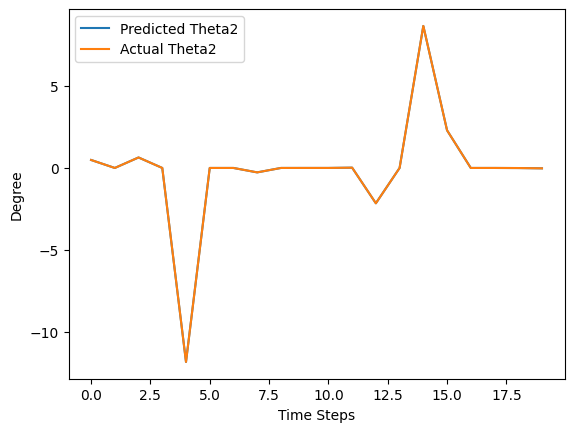

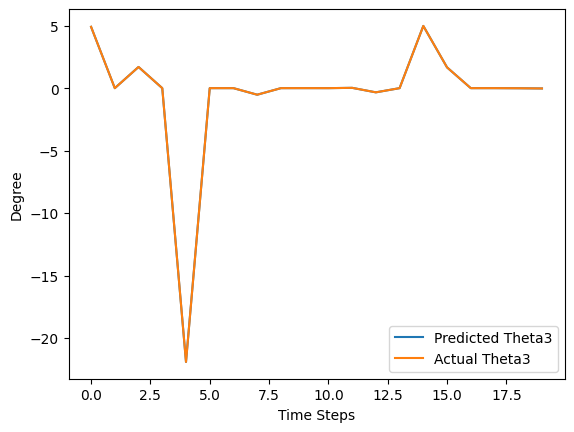

In [3]:
# Initialize the model
model = LinearRegression()

model.fit(X_train, y_train)

# Training
train_pred = model.predict(X_train)
train_loss = mean_squared_error(y_train, train_pred)

# Validation
val_pred = model.predict(X_val)
val_loss = mean_squared_error(y_val, val_pred)

# Evaluation on the train, validation, and test sets
train_rmse = np.sqrt(train_loss)
train_r2 = r2_score(y_train, train_pred)
val_rmse = np.sqrt(val_loss)
val_r2 = r2_score(y_val, val_pred)
test_pred = model.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))
test_r2 = r2_score(y_test, test_pred)

#print metrics
print(f'Train RMSE: {train_rmse:.10f}')
print(f'Train R^2 Score: {train_r2}')
print(f'Validation RMSE: {val_rmse:.10f}')
print(f'Validation R^2 Score: {val_r2}')
print(f'Test RMSE: {test_rmse:.10f}')
print(f'Test R^2 Score: {test_r2}')

# Inverse transform the predictions and true values
test_pred = scaler.inverse_transform(test_pred)
y_test = scaler.inverse_transform(y_test)

#Plot actual vs predicted angles
plt.plot(test_pred[0:20, 0], label='Predicted Theta1')
plt.plot(y_test[0:20, 0], label='Actual Theta1')
plt.xlabel('Time Steps')
plt.ylabel('Degree')
plt.legend()
plt.show()

plt.plot(test_pred[0:20, 1], label='Predicted Theta2')
plt.plot(y_test[0:20, 1], label='Actual Theta2')
plt.xlabel('Time Steps')
plt.ylabel('Degree')
plt.legend()
plt.show()

plt.plot(test_pred[0:20, 2], label='Predicted Theta3')
plt.plot(y_test[0:20, 2], label='Actual Theta3')
plt.xlabel('Time Steps')
plt.ylabel('Degree')
plt.legend()
plt.show()